# DeepTrack - Generating point particles

This notebook will demonstrate how to easily generate point particles and define custom features.


## Setup

Top level code includes the import statement of the classes we will need, as well as adding the path of the DeepTrack module to out path. This last step is only needed if the module is downloaded through git instead of installed as a package.

In [21]:
import sys
sys.path.append("..") # This adds the DeepTrack module to our path.

from DeepTrack.Generators import Generator
from DeepTrack.Particles import PointParticle
from DeepTrack.Optics import BaseOpticalDevice2D

import numpy as np
import matplotlib.pyplot as plt

## Creating the generator

The generator is the interface between the network and the image creation. It requires no input to be created.

In [22]:
G = Generator()

## Defining the optics 

To image an object we need to define the properties of the optical system. This is done using an Optics instance. The role of the Optics instance is to take a number of light sources and correctly convolve them with the pupil function. It also handles summing multiple light sources correctly.

As of writing this, the optics is controlled by the following parameters:

* NA: The NA of the limiting aperature

* wavelength: The wavelength of the lightsource (m)

* pixel_size: The pixel to meter conversion factor

* mode: "coherent" vs "incoherent", models the light emitted by a object

* ROI: Specifies the region of the field that is imaged. Useful for avoiding wrap-around effects when doing fourier tranforms

* upscale: How far to upscale the generated pupil-function. This is a cheap way to increase output accuracy.

In [23]:
Optics = BaseOpticalDevice2D(
    NA=0.7,                
    pixel_size=0.1e-6,     
    wavelength=0.68e-6     
)

## Defining the image

The generator takes a set of features, which are rules for generating an image, and creates an Image instance.

In this case we a single object, or feature, a particle. The particle object, for instance, contain all the information needed to image a random instance of that particle. This randomization may include properties such as its position or its intensity, and is determined by input parameters.

A simple point particle, or a point source, is entirely defined by its intensity and its position.

In [24]:
P = PointParticle(                                         
    intensity=100,
    position=(32,32,0)
)

## Generating the image

Finally, we have everything needed to create an image! This is done using the class method `Generator.get`. This returns an Image object. This behaves exactly like a normal numpy ndarray, just additionally storing the properties used to generating the image as a list of dicts. More on this later

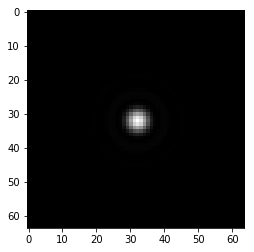

In [25]:
Image = G.get((64,64), Optics(P))
plt.gray()
plt.imshow(Image)
plt.show()

## More features

That's neat and all, but how do we do something more complicated? By adding features together! Let us add a second particle. 

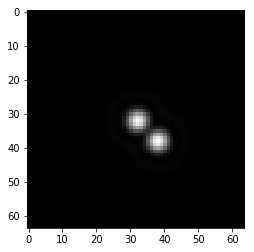

In [26]:
P2 = PointParticle(
    intensity=100,
    position=(38,38,0)
)

Image = G.get((64,64),Optics(P + P2))
plt.gray()
plt.imshow(Image)
plt.show()

## Creating your own feature

Creating your own custom feature is easy! Let's define our own custom noise. For a feature that is not wrapped inside a Optics() call, you only need to define a single method: get(). Let's create a GaussianNoise class that adds Gaussion noise to the image. Then we'll try to understand what happens in the backend.

In [17]:
from DeepTrack.Features import Feature

class GaussianNoise(Feature):
    def get(self, shape, Image, mu=0, sigma=1, **kwargs):
        mu =    np.ones(shape) * mu
        sigma = np.ones(shape) * sigma
        return Image + np.random.normal(mu, sigma)

## Understanding how it works

### What are the inputs?
The get function seems to have two non-keyword arguments, and at least two keyword arguments. The first is shape, this is the desired output shape of the image. The second argument is Image, which is the current image upon which you add your feature. Passing it through the get function allows for non-additive features, such as poisson noise. 

The keyword arguments are harder to understand at first. mu and sigma seems like reasonable arguments for gaussian noise, but how does it know to recieve those arguments? Where are they defined? They are defined when you create an instance of the class! Every keyword argument that is passed through the Feature constructor is added to an attribut called __properties__. When get is called, a "smart copy" of the __properties__ field is sent to the get function. This allows the backend Feature class to handle how these properties are updated and evolve over time.

To make this a little bit more clear, let's add a __init__ function.

In [27]:
class GaussianNoise(Feature):
    
    def __init__(self, mu=0, sigma=1, **kwargs):
        super().__init__(mu=mu, sigma=sigma, **kwargs)
        
    def get(self, shape, Image, mu=0, sigma=1, **kwargs):
        mu =    np.ones(shape) * mu
        sigma = np.ones(shape) * sigma
        return Image + np.random.normal(mu, sigma)

Note that this definition is almost exactly equivalent to the first definition. In fact, very rarely is the __init__ contructor needed. The only difference here, is that mu and sigma is guaranteed to be in the __properties__ field. This may be important due to a second function of the __properties__ field. Whenever an image is generated through a Feature.get() call, a dict is added to a list which contains information about how the image was generated. This dict is an exact copy of the "smart copy" of the __properties__ field. By guaranteeing that mu and sigma is in the __properties__ field, you also guarantee that it is added to this list of properties.

Now we can generate an image with added noise!

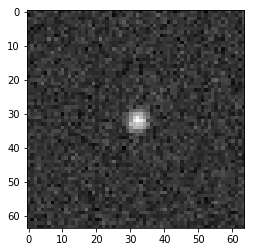

In [28]:
N = GaussianNoise(mu=0, sigma=0.01)

Image = G.get((64,64),Optics(P) + N)
plt.gray()
plt.imshow(Image)
plt.show()